# PHYS20762 - Project 2 - Numerical Integration of Differential Equations 
# The Damped Harmonic Oscillator

George McNie<br>
University of Manchester 
April 2021

The python interpretor is initialised

In [55]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [56]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
from scipy.signal import find_peaks
from scipy.interpolate import UnivariateSpline
from matplotlib import rc

"""
#stops scrolling in figures
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
"""

plt.rcParams.update({'font.size': 14})
#plt.rcParams['text.usetex'] = True
plt.style.use('ggplot')

During this report a spring-mass system is investigated when it is subject to an external force F(t), giving rise to the equation:
$$m\frac{\mathrm{d}^2x }{\mathrm{d} t^2} + b\frac{\mathrm{d} x}{\mathrm{d} t} + kx = F(t),$$

where x is a function of time giving the position, m is the mass of the mass, b is the damping and k is the spring constant. 

The physical parameters and initial conditions of the system are defined as:

In [57]:
# defining the constants of the system as given by the class list

k = 0.62 # in units of kg/s^2
m = 3.67 # units of kg

#setting the initial conditions (as described below)
x_0 = 0 #mass starts at postion 0, x(t=0)
v_0 = -1 #initial velocity of the mass given in m/s,  v(t=0)
T = 300 # how long we are integrating for (in s)
h = 0.1 # the step size (in s)
n_steps = int(T/h) #total number of steps in integration (int to ensure we have a whole number of them, 
                  #otherwise the loops won't work)

## Solutions where F(t) = 0

Four different numerical methods are to be investigated to solve the equation,
$$m\frac{\mathrm{d}^2x }{\mathrm{d} t^2} + b\frac{\mathrm{d} x}{\mathrm{d} t} + kx = 0.$$
These programs will caluclate x(t) for each of the following methods:
- Euler
- Improved Euler
- Verlet
- Euler-Cromer<br>

All of these methods can then be compared to the analytical solution to demonstrate the differences between the methods and thus which is the best to take forwards when solving for the equation when $F(t) \neq 0$.

### Euler's Method

In Euler's method the position and velocity after an infinitesimal time step h later will be given by,
$$x_{i+1} = x_{i} + h \cdot v_{i}$$ 
$$v_{i+1} = v_{i} + h \cdot a_{i},$$    
where  
$$a_{i} = -\frac{k}{m} x_{i} -\frac{b}{m} v_{i}.$$ Here $i$ labels the number of steps taken (each of size $h$ in time).

In [58]:
def euler(integration_steps, h, b):
    """
    function that performs euler's method as described above

    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant

    Returns
    -------
    x : numpy array
        the position of the mass at time throughout process
    v : numpy array
        the velocity of the mass at time throughout process

    """
    #create empty array for velocities and positions 
    x = np.zeros(integration_steps)
    v = np.zeros(integration_steps)
    
    #insert the initial conditions specified as global constants before
    x[0] = x_0
    v[0] = v_0
    
    #perform calculation
    for i in range(integration_steps-1):
        a = -(k/m)*x[i] - (b/m)*v[i] # Calculate the acceleration at step i (in m/s)
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        x[i+1] = x[i] + v[i]*h
        v[i+1] = v[i] + a*h
        
    return (x, v)
    

The accuracy of this numerical method can be seen from a Taylor expansion
$$x(t+h) = x + h\frac{\mathrm{d} x(t)}{\mathrm{d} t} + \frac{1}{2}h^2\frac{\mathrm{d}^2x(\tau) }{\mathrm{d} t^2}$$ 
where $ t<\tau<t+h $.<br>
This is then inserted into the equation for velocity,
$$v=\frac{\mathrm{d} x}{\mathrm{d} t} = \lim_{x\to \ 0}(\frac{x(t+h) - x(t)}{h})$$
resulting in an error = $\frac{1}{2}h\frac{\mathrm{d}^2x(\tau) }{\mathrm{d} t^2}$ which is of the order $h^2$.


### Improved Euler

An improved Euler's method is devised to make the error a higher order of h. This is done by having an extra term in the Taylor expansion:
$$x(t+h) = x + h\frac{\mathrm{d} x(t)}{\mathrm{d} t} + \frac{1}{2}h^2\frac{\mathrm{d}^2x(t) }{\mathrm{d} t^2} + error$$
where the error is of the order $h^3$. This gives that:
$$x_{i+1} = x_{i} + h \cdot v_{i} + \frac{h^2}{2} \cdot a_{i}^2$$ 
$$v_{i+1} = v_{i} + h \cdot a_{i}.$$  
Implementing it as follows:

In [59]:
def imp_euler(integration_steps, h, b):
    """
    function that describes the improved Euler method as described above

   Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant

    Returns
    -------
    x : numpy array
        the position of the mass at time throughout process
    v : numpy array
        the velocity of the mass at time throughout process

    """
    #create empty array for velocities and positions 
    x = np.zeros(integration_steps)
    v = np.zeros(integration_steps)
    
    #insert the initial conditions specified as global constants before
    x[0] = x_0
    v[0] = v_0
    
    #perform calculation
    for i in range(integration_steps-1):
        a = -(k/m)*x[i] - (b/m)*v[i] # Calculate the acceleration at step i (in m/s)
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        x[i+1] = x[i] + v[i]*h + ((h**2)*a)/2
        v[i+1] = v[i] + a*h
        
    return (x, v)

### Verlet's method

This method relies on a centered derivative which is given by
$$v = x'(t) =\frac{\mathrm{d} x}{\mathrm{d} t} = \lim_{x\to \ 0}(\frac{x(t+h) - x(t-h)}{2h})$$
and by using the Taylor expansions: <br>
$x(t+h)= x(t) +hx'(t)+ \frac{1}{2}h^2x''(t)+ \frac{1}{6}h^3x'''(\tau)$ <br>
$x(t-h) = x(t) -hx'(t)+ \frac{1}{2}h^2x''(t)- \frac{1}{6}h^3x'''(\tau)$ where $t-h < \tau < t+h$.

These equations lead to:
$$x'(t) = \frac{x(t+h)- x(t-h)}{2h} + \frac{1}{6}h^2x'''(\tau)$$ and 
$$x''(t) = \frac{x(t+h)- x(t-h)-2x(t)}{h^2} - \frac{1}{12}h^2x''''(\tau)$$
where the errors in these separate equations are of the order $h^2$.
A set of equations is thus set up
$$x_{i+1} = 2x_{i} - x_{i-1} + h^2a_{i}$$ with error of order $h^4$
$$a_{i} = \frac{-k}{m}x_i- \frac{b}{m}v_i$$
$$v_i = \frac{x_{i+1}-x_{i-1}}{2h}$$
The downside of these equations is that they cannot be solved separately and have to be solved simultaneously, the subsequent i is needed and so rearranging:
$$x_{i+1} = Ax_i + Bx_{i-1}$$
where $A = \frac{2(2m-kh^2)}{2m+bh}$ and $B = \frac{bh-2m}{2m+bh}$.
This equation however relies on the current term and previous term so to start off this method a different one must be used to get these.

In [60]:
def verlet(integration_steps, h,  b):
    """
    function that describes the Verlet method as described above

   Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant

    Returns
    -------
    x : numpy array
        the position of the mass at time throughout process
    v : numpy array
        the velocity of the mass at time throughout process

    """
    #create empty array for velocities and positions 
    x = np.zeros(integration_steps)
    v = np.zeros(integration_steps)
    
    #insert the initial conditions specified as global constants before
    x[0] = x_0
    v[0] = v_0
    
    #obtain x_1 from improved euler method so that verlet can be started 
    #massive run time if call function and get all values of x and v, quicker to work out
    a_0 = -(k/m)*x[0] - (b/m)*v[0]
    x[1] = x[0] + v[0]*h + a_0*((h**2)/2)
    v[1] = v[0] + a_0*h
    
    #perform calculation
    A = ((4*m) - 2*k*(h**2)) / (2*m+b*h)
    B = (b*h - 2*m) / (2*m+b*h)
         
    for i in range(1, integration_steps-1):
            x[i+1] = A * x[i] + B*x[i-1]
            v[i] = (x[i+1] - x[i-1]) / (2*h)
        
    return (x, v)

### Euler-Cromer Method

This method is devised because with the Euler method there is predicted to be a steadily increasing energy, which is wrong (as explored later analytically):
$$ E_{i+1} = \frac{1}{2}kx_{i+1}^2 + \frac{1}{2}kv_{i+1}^2 = E_i(1+ \frac{k}{m}h^2) $$ 
This leads to the Euler-Cromer method which is symplectic (energy of system doesn't change). This is done by saying
$$x_{i+1} = x_i +hv_{i+1}$$
$$ v_{i+1} = v_i + a_ih$$ 
the value of the next x thus depends on the next v not the current one.
This is a symplectic integrator proven by showing the value of energy:
$$ E_{i+1} = E_i - \frac{1}{2}h^2(\frac{k^2x_0^2}{m} - kv_i^2) - \frac{k^2x_iv_i}{m}h^3+\frac{k^3x_i^2}{2m^2}h^4 = E_i + x$$
where x averages to zero over a full oscillation.
It's implemented below:

In [61]:
def euler_cromer(integration_steps, h, b):
    """
    function that describes the Euler-Cromer method as described above

   Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant

    Returns
    -------
    x : numpy array
        the position of the mass at time throughout process
    v : numpy array
        the velocity of the mass at time throughout process

    """
    #create empty array for velocities and positions 
    x = np.zeros(integration_steps)
    v = np.zeros(integration_steps)
    
    #insert the initial conditions specified as global constants before
    x[0] = x_0
    v[0] = v_0
    
    #perform calculation
    for i in range(integration_steps-1):
        a = -(k/m)*x[i] - (b/m)*v[i]
        
        # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
        v[i+1] = v[i] + a*h
        x[i+1] = x[i] + v[i+1]*h
        
    return (x, v)


### Analytical Solution

The system can be damped in one of three ways:
- lightly damped $\to 4km - b^2 > 0 $    OR    $\frac{\gamma^2}{4} < \omega_0^2$
- Critically damped $\to 4km - b^2 = 0 $    OR    $\frac{\gamma^2}{4} = \omega_0^2$
- Overdamped $\to 4km - b^2 < 0 $    OR    $\frac{\gamma^2}{4} > \omega_0^2$

When the system is not critically damped $b = 2(km)^{1/2}$ and this leads to the solution
$$x(t) = e^\frac{-\gamma t}{2}(Ae^{i\omega t} + Be^{-i\omega t})$$
where $\gamma = b / m$. This results in the frequency of the system being 
$$ \omega^2 = \omega_0^2 - \frac{\gamma^2}{4}$$
where $\omega_0$ is the natural frequency of the system with $\omega_0 = (k/m)^{1/2}$ and A and B are constants which depend upon the initial conditions.<br>
When the system is damped critically the mass spring system reaches equilibrium in the shortest time possible without oscillating, given by
$$ x(t) = Ge^{-\frac{\gamma}{2}t}+ Hte^{-\frac{\gamma}{2}t} ,$$
where G and H are constants which depend upon the initial conditions.<br>
The code for the analytical solution is:

In [62]:
def analytical_sol(integration_steps, h, b):
    """
    The solution of the undamped problem done analytically
    
    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant

    Returns
    -------
    x : numpy array
        the position of the mass
    v : numpy array
        the velocity of the mass 


    """
    #defining frequently used constants
    gamma = b/m #the damping ratio
    b_crit = 2*np.sqrt(k*m)
    freq = cmath.sqrt((k/m) - (gamma**2)/4) #frequency of oscillations
    C_1 = 4*k*m - b**2
    A = (b/(2*1j*cmath.sqrt(C_1))+1/2)*x_0+v_0*m/(cmath.sqrt(C_1)*1j) 
    B = x_0 - A
    G = x_0
    H = (G*gamma)/2 + v_0
   
    #get the time intervals that need to calculate position and velocity for
    time = np.linspace(0, T, integration_steps)
    
    if (b == b_crit): #the critically damped case
        x = G*np.exp((-gamma*time)/2) + H*time*np.exp((-gamma*time)/2)
        v = -G*(gamma/2)*np.exp((-gamma*time)/2) + H*np.exp((-gamma*time)/2) - H*(gamma/2)*time*np.exp((-gamma*time)/2)
    else:
        x = np.exp(-gamma*time/2) * (A*np.exp((1j*freq*time)) + B*np.exp(-1j*freq*time))
        v = np.exp((-gamma*time/2)) * ((-gamma/2)*(A*np.exp(1j*freq*time) + B*np.exp(-1j*freq*time)) + 
                                       A*1j*freq*np.exp(1j*freq*time) - B*1j*freq*np.exp(-1j*freq*time))
    x = np.real(x)
    v = np.real(v)
    return (x, v)
                   

### Plot Results

The four methods are plotted below for $b=0.2$, on each of the graphs the true analytical solution is also plotted to see how well each method models the system.

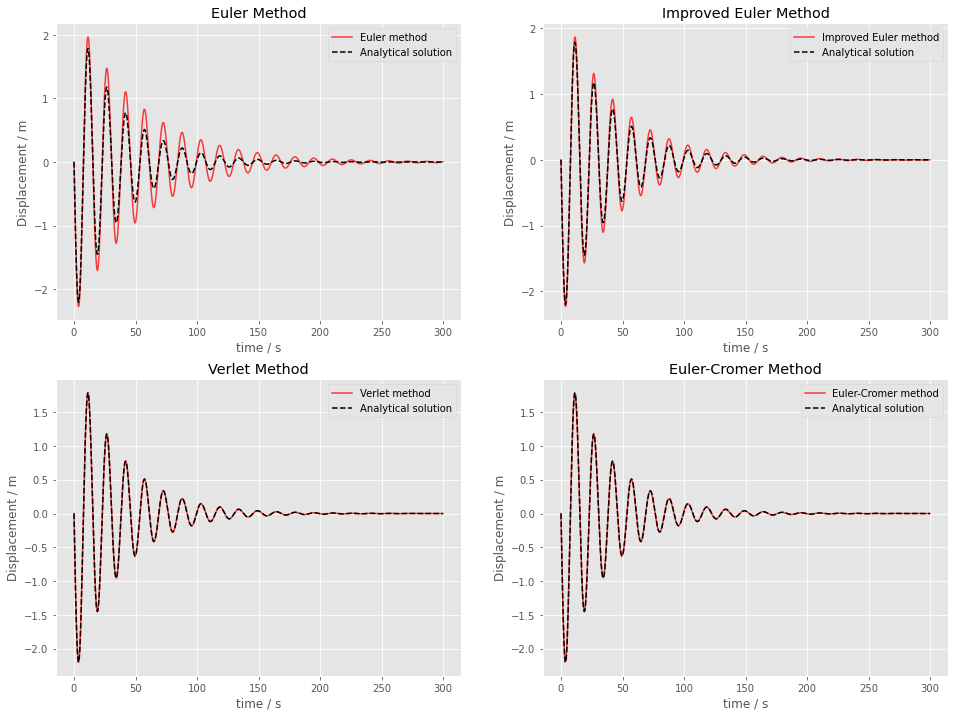

In [63]:
#Creating an array of time intervals using the initial conditions of h and nsteps
time = np.linspace(0, T-h, num = n_steps) 

#vals obtained for position and velocity from for methods
x_E, v_E = euler(n_steps, h, 0.2)
x_impE, v_impE = imp_euler(n_steps, h, 0.2)
x_V, v_V = verlet(n_steps, h, 0.2)
x_EC, v_EC = euler_cromer(n_steps, h, 0.2)
x_An, v_An = analytical_sol(n_steps, h, 0.2)

plt.figure(figsize=(16, 12)) #sets the figure size

#Euler method subplot
plt.subplot(2, 2, 1)
plt.plot(time, x_E, 'r', label='Euler method', alpha = 0.75)
plt.plot(time, x_An, 'k', linestyle = '--', label='Analytical solution')
plt.xlabel('time / s')
plt.ylabel('Displacement / m')
plt.title('Euler Method')
plt.legend()

#Improved Euler method subplot
plt.subplot(2, 2, 2)
plt.plot(time, x_impE, 'r', label='Improved Euler method', alpha = 0.75)
plt.plot(time, x_An, 'k', linestyle = '--',  label='Analytical solution')
plt.xlabel('time / s')
plt.ylabel('Displacement / m')
plt.title('Improved Euler Method')
plt.legend()

#Verlet method subplot
plt.subplot(2, 2, 3)
plt.plot(time, x_V, 'r', label='Verlet method', alpha = 0.75)
plt.plot(time, x_An, 'k', linestyle = '--', label='Analytical solution')
plt.xlabel('time / s')
plt.ylabel('Displacement / m')
plt.title('Verlet Method')
plt.legend()

#Euler-Cromer method subplot
plt.subplot(2, 2, 4)
plt.plot(time, x_EC, 'r', label='Euler-Cromer method', alpha = 0.75)
plt.plot(time, x_An, 'k', linestyle = '--', label='Analytical solution')
plt.xlabel('time / s')
plt.ylabel('Displacement / m')
plt.title('Euler-Cromer Method')
plt.legend()

plt.show()

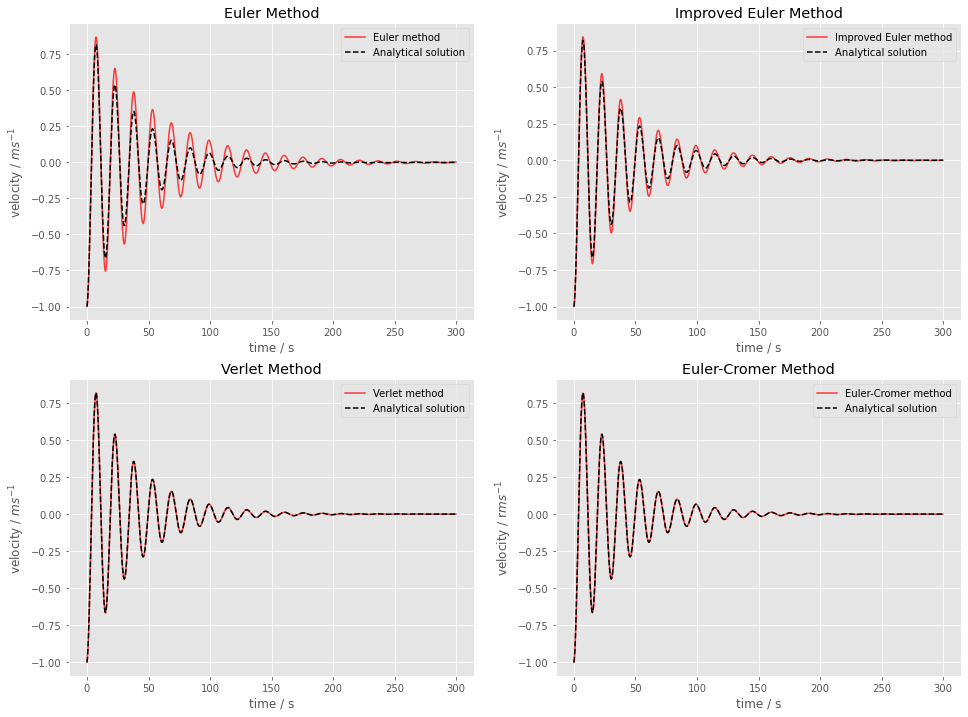

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 12)) #sets the figure size

plt.subplot(2, 2, 1)
plt.plot(time, v_E, 'r', label='Euler method', alpha = 0.75)
plt.plot(time, v_An, 'k', linestyle = '--', label='Analytical solution')
plt.xlabel('time / s')
plt.ylabel('velocity / ' r'$ms^{-1}$')
plt.title('Euler Method')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(time, v_impE, 'r', label='Improved Euler method', alpha = 0.75)
plt.plot(time, v_An, 'k', linestyle = '--',  label='Analytical solution')
plt.xlabel('time / s')
plt.ylabel(r'velocity / ' r'$ms^{-1}$')
plt.title('Improved Euler Method')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(time, v_V, 'r', label='Verlet method', alpha = 0.75)
plt.plot(time, v_An, 'k', linestyle = '--', label='Analytical solution')
plt.xlabel('time / s')
plt.ylabel('velocity / ' r'$ms^{-1}$')
plt.title('Verlet Method')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(time, v_EC, 'r', label='Euler-Cromer method', alpha = 0.75)
plt.plot(time, v_An, 'k', linestyle = '--', label='Analytical solution')
plt.xlabel('time / s')
plt.ylabel('velocity / ' 'r$ms^{-1}$')
plt.title('Euler-Cromer Method')
plt.legend()

plt.show()

For the Euler and improved Euler method, the method deviates from the analytical solution quite considerably, this is discussed in the next section. Whereas for Verlet's and the Euler-Cromer method the curves are almost identical.

### Time step and energy

The energy of the system is given by the sum of the kinetic and potential energies,
$$ E = \frac{1}{2}kx^2 +\frac{1}{2}mv^2 $$
As discussed before the Euler-Cromer method is a symplectic method. The Verlet method is also symplectic, which should mean that these methods produce results closer to the analytical solution as they both conserve energy. Euler's method and the improved Euler's method will obtain values of energy increase so that
$$ E_{i+1} = E_{i}(1+\frac{k}{m}h^2).$$
This is proved to be wrong when analytically solved and the case of
$$x(t)=x_0e^{-\frac{\gamma}{2}t} cos(\omega t)$$
is considered. This gives
$$E = \frac{x_0^2e^{\frac{\gamma}{2}t}}{8m}(4km+b^2cos(2\omega t)+2mb\omega cos(2\omega t)).$$
When the case of $b=0$ is considered,
$$E(t)=\frac{kx_0^2}{2},$$
showing our equation for energy increasing with the Euler and improved Euler method to be wrong.<br>
The value of energy is used to directly observe the accuracy of different methods. 

In [65]:
def calc_energy(x,v):
    """
    calculates the energy of the mass at a certai position using it's position and velocity at that position

    Parameters
    ----------
    x : numpy array
        value of x at given step
    v : numpy array
        value of velocity at a given step

    Returns
    -------
    E : numpy array
        returns the energy at each given ste

    """
    E = 1/2 *k*(x**2) + 1/2 * m*(v**2)
    
    return(E)


The time step used determines the accuracy of different methods.<br>
The accuracy of a certain method is measured as follows, for every value of x(t) and v(t) the energy is also calculated and compared to the analytical solution by measuring a percentage uncertainty:
$$ \frac{\left | E_{analytical}-E_{numerical} \right |}{E_{analytical}}.$$
An average of these percentage uncertainties is then taken to give an overall value of the percentage uncertainty for a certain value h.

In [66]:
def uncertainty_E(integration_steps, h, b):
    """
    calculates the average uncertainty on the Euler method using by calculating average error at each point and averaging them 
    all

    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant

    Returns
    -------
    Euler_uncert_av: float
        the average uncertainty given as a percentage

    """
    x_E, v_E = euler(integration_steps, h, b)
    x_ana, v_ana = analytical_sol(integration_steps, h, b)
    #calculating the energies using the numerical values calculated in each method
    E_Euler_num = calc_energy(x_E, v_E)
 
    #energy of analytical sol
    E_ana = calc_energy(x_ana, v_ana)
    
    #calc percentage uncertainty on each value, each value stored in the numpy array
    Euler_percent = 100 * (np.abs(E_ana - E_Euler_num))/E_ana
       
    #calc the average value of each percentage uncertainty
    Euler_uncert_av = np.mean(Euler_percent)
    
    return(Euler_uncert_av)

def uncertainty_imp_E(integration_steps, h, b):
    """
    calculates the average uncertainty on the improved Euler method using by calculating average error at each point and 
    averaging them all

    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant

    Returns
    -------
    imp_Euler_uncert_av: float
        the average uncertainty given as a percentage
    """
    
    x_impE, v_impE = imp_euler(integration_steps, h, b)   
    x_ana, v_ana = analytical_sol(integration_steps, h, b)
    #calculating the energies using the numerical values calculated in each method
    E_imp_Euler_num = calc_energy(x_impE, v_impE)
    
    #energy of analytical sol
    E_ana = calc_energy(x_ana, v_ana)
    
    #calc percentage uncertainty on each value, each value stored in the numpy array
    imp_Euler_percent = 100 * (np.abs(E_ana - E_imp_Euler_num))/E_ana
    
    #calc the average value of each percentage uncertainty
    imp_Euler_uncert_av = np.mean(imp_Euler_percent)
    
    return(imp_Euler_uncert_av)

def uncertainty_Ver(integration_steps, h, b):
    """
    calculates the average uncertainty on the Verlet method using by calculating average error at each point and averaging them 
    all

    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant


    Returns
    -------
    Ver_uncert_av: float
        the average uncertainty given as a percentage
    """
    x_V, v_V = verlet(integration_steps, h, b)  
    x_ana, v_ana = analytical_sol(integration_steps, h, b)
    #calculating the energies using the numerical values calculated in each method
    E_Ver_num = calc_energy(x_V, v_V)
    
    #energy of analytical sol
    E_ana = calc_energy(x_ana, v_ana)
    
    #calc percentage uncertainty on each value, each value stored in the numpy array
    Ver_percent = 100 * (np.abs(E_ana - E_Ver_num)) / E_ana
    
    #calc the average value of each percentage uncertainty
    Ver_uncert_av =  np.mean(Ver_percent)
    
    return(Ver_uncert_av)

def uncertainty_EC(integration_steps, h, b):
    """
    calculates the average uncertainty on the Euler-Cromer method using by calculating average error at each point and 
    averaging them all

    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant


    Returns
    -------
    Eu_Crom_uncert_av: float
        the average uncertainty given as a percentage
    """
    x_EC, v_EC = euler_cromer(integration_steps, h, b)
    x_ana, v_ana = analytical_sol(integration_steps, h, b)
    
    #calculating the energies using the numerical values calculated 
    E_Eu_Cro_num = calc_energy(x_EC, v_EC)
    
    #energy of analytical sol
    E_ana = calc_energy(x_ana, v_ana)
    
    #calc percentage uncertainty on each value, each value stored in the numpy array
    Eu_Crom_percent = 100 * (np.abs(E_ana - E_Eu_Cro_num))/E_ana
    
    #calc the average value of each percentage uncertainty
    Eu_Crom_uncert_av = np.mean(Eu_Crom_percent)
    
    return(Eu_Crom_uncert_av)

The functions above will calculate the uncertainties on a given value of h for every method used. The uncertainty for many values of h needs to be calculated, to assess the optimal time step.

In [67]:
#creates a list of evenly spaced step sizes
h_values = np.linspace(0.001,0.1,100)
n_steps_list = T/h_values
n_steps_list = n_steps_list.astype(int)

#create empty arrays for uncertainty values to go in
Euler_uncert = np.zeros(len(n_steps_list))
imp_E_uncert = np.zeros(len(n_steps_list))
Ver_uncert = np.zeros(len(n_steps_list))
E_C_uncert = np.zeros(len(n_steps_list))

#get value for the uncertainties 
for i, h_value in enumerate(h_values): 
    int_steps = int(T/ h_value)
    Euler_uncert[i] = uncertainty_E(int_steps ,h_value, 0.2)
    imp_E_uncert[i] = uncertainty_imp_E(int_steps ,h_value, 0.2)
    Ver_uncert[i] = uncertainty_Ver(int_steps ,h_value, 0.2)
    E_C_uncert[i] = uncertainty_EC(int_steps ,h_value, 0.2)

Now have an array of uncertainties for each method corresponding to a particular step size.

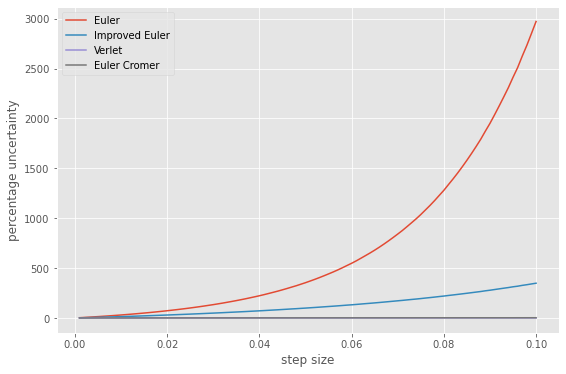

In [68]:
plt.figure(figsize=(9,6))

plt.plot(h_values, Euler_uncert, label = 'Euler')
plt.plot(h_values, imp_E_uncert, label = 'Improved Euler')
plt.plot(h_values, Ver_uncert, label = 'Verlet')
plt.plot(h_values, E_C_uncert, label = 'Euler Cromer')
plt.xlabel('step size')
plt.ylabel('percentage uncertainty')
plt.legend()

plt.show()

As seen in the graph above the accuracy of the Euler and Improved Euler method is worse than the other two as predicted (lower order of error). However it's difficult to see if the Verlet or Euler Cromer method is better (one line conceals the other) so  a new figure of those two methods is created:

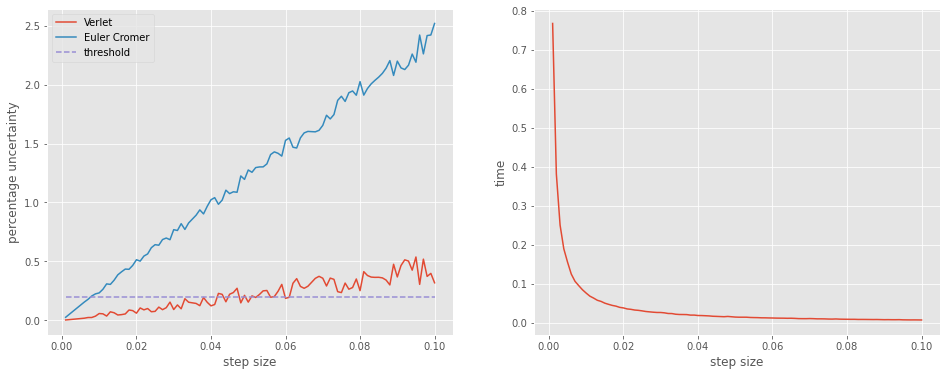

In [69]:
import time

def verlet_time(T, h, b):
    """
    calculates the amount of time the verlet function takes for given parameters

    Parameters
    ----------
    T : float/integer
        the time period looking over
    h : float
        the step size
    b : float
        the damping coefficient

    Returns
    -------
    the time takes for function to run

    """
    n_steps = int(T/h)
    start = time.time()
    verlet(n_steps,h, b)
    end = time.time()
    return(end-start)

verlet_time_arr = np.zeros(len(n_steps_list))

for i in range(len(h_values)):
    verlet_time_arr[i] = verlet_time(T, h_values[i] , 0.2)


plt.figure(figsize=(16,6))

threshold = np.full((len(h_values),),0.2)


plt.subplot(1, 2, 1)
plt.plot(h_values, Ver_uncert, label = 'Verlet')
plt.plot(h_values, E_C_uncert, label = 'Euler Cromer')
plt.plot(h_values, threshold, label = 'threshold', linestyle = '--')
plt.xlabel('step size')
plt.ylabel('percentage uncertainty')
plt.legend()

plt.subplot(1, 2, 2)

plt.plot(h_values, verlet_time_arr)
plt.xlabel('step size')
plt.ylabel('time')

#explore percentage uncertainty against b before the critical value


plt.show()

It is clear from this that Verlet's method is better than the Euler-Cromer method as you get a lower percentage uncertainty for any given step size for $b=0.2$. Despite local fluctuations it can be said that the uncertainty is inversely proportional to the step size.<br>

The efficiency of the program is dependent on the step size, with a lower step size having a lower percentage uncertainty but the program time will be extremely high. For the Verlet method for example the difference in time taken is for different step sizes as seen in the right hand plot. It can be seen that the efficiency of the program rapidly decreases when a step size lower than 0.02 is used. To get the perfect balance between program efficiency and accuracy, the allowed percentage uncertainty in our program is set to be:
$$\sigma \leq 0.02 \% $$
this aquires a step size of $h=0.04$.


In [70]:
#setting all values of to the optimal parameters
T = 300
h = 0.04
n_steps = int(T/h)
time = np.linspace(0, T-h, n_steps) 

### Varying damping terms


Now that Verlet's method has been discovered to be the best method and the optimal time step has been found, different damping constants are investigated. Critical damping occurs when
$$ b_{critical}^2 = 4km.$$
Plotted below are $b = \frac{b_{cr}}{2}$, $b=b_{cr}$ and $b=2b_{cr}$ which represent light damping, critical damping and overdamping respectively.

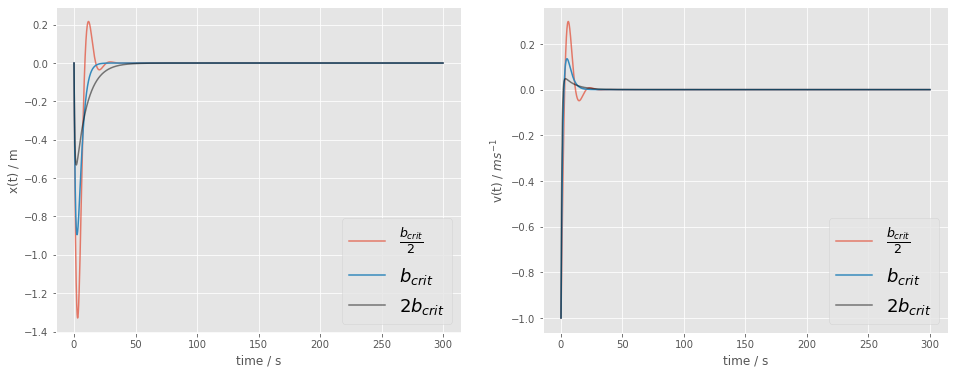

In [71]:
b_crit = np.sqrt(4*k*m) # the b at which critical damping occurs

x_b_half, v_b_half= verlet(n_steps, h,  b_crit/2)
x_b_crit, v_b_crit = verlet(n_steps, h,  b_crit)
x_b_double, v_b_double= verlet(n_steps, h,  2*b_crit)

#plotting the position and velocity of different b's 
plt.figure(figsize=(16,6))

#position plot
plt.subplot(1, 2, 1)
plt.plot(time, x_b_half, label = r"$ \frac{b_{crit}} {2}$ ", alpha = 0.7)
plt.plot(time, x_b_crit, label = r'$b_{crit}$')
plt.plot(time, x_b_double, label = r'$2b_{crit}$', color='k', alpha = 0.5)
plt.xlabel('time / s')
plt.ylabel('x(t) / m')
plt.legend(loc=4, prop={'size': 18})

#velocity plot
plt.subplot(1, 2, 2)
plt.plot(time, v_b_half, label = r'$\frac{b_{crit}}{2}$', alpha = 0.7)
plt.plot(time, v_b_crit, label = r'$b_{crit}$')
plt.plot(time, v_b_double, label = r'$2b_{crit}$', color='k', alpha = 0.5)
plt.xlabel('time / s')
plt.ylabel(r'v(t) / $ms^{-1}$')
plt.legend(loc=4, prop={'size': 18})

plt.show()

When the system is lightly damped the mass' position oscillates around equilibrium with gradually decreasing values of amplitude as expected.

When the system is critically damped the mass' position doesn't oscillate at all.

When the system is overdamped it the mass reaches equilibrium slower than when it's critically damped

## External Force Applied

Now that testing has been done of a method against a known solution, that method is applied to our unknown solution involving the equation
$$m\frac{\mathrm{d}^2x }{\mathrm{d} t^2} + b\frac{\mathrm{d} x}{\mathrm{d} t} + kx = F(t).$$
The accurate numerical method of Verlet allows us to model and find solutions to this equation.



### Sudden application of force


Here the behaviour of the system when a sudden force is applied (like a push) after a few oscillation periods is explored. To explore this Verlet's method has to be re-written to take into account the force. 

This is done by splitting the method into two: before the applied force and after:

In [72]:
def sudden_push(integration_steps, h,  b, F, F_time):
    """
    funtion that calculates the position and velocity of mass using Verlet's method, and when a sudden push occurs.

    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant
    F : float
        the force that the mass is pushed with
    F_time : float
        the time force occurs

    Returns
    -------
    x : numpy array
        position of the mass .
    v : numpy array
        velocity of the mass.
    """
    #create empty array for velocities and positions 
    x = np.zeros(integration_steps)
    v = np.zeros(integration_steps)
    
    #insert the initial conditions specified as global constants before
    x[0] = x_0
    v[0] = v_0
    
    #obtain x_1 from improved euler method so that verlet can be started 
    #massive run time if call function and get all values of x and v, quicker to work out
    a_0 = -(k/m)*x[0] - (b/m)*v[0]
    x[1] = x[0] + v[0]*h + a_0*((h**2)/2)
    v[1] = v[0] + a_0*h
    
    #locate at what step the force is applied (closest to the step therefore only accurate to half the time step)
    F_step = int(F_time/h)
    
    #perform calculation
    A = ((4*m) - 2*k*(h**2)) / (2*m+b*h)
    B = (b*h - 2*m) / (2*m+b*h)
    
    for i in range(1, F_step-1):
            x[i+1] = A * x[i] + B*x[i-1]
            v[i] = (x[i+1] - x[i-1]) / (2*h)
    
    #acceleration of mass after push
    a_after = -(k/m)*x[F_step] - (b/m)*v[F_step] + F/m
    
    #obtain x and v from improved euler method just after push so that verlet can be started 
    x[F_step + 1] = x[F_step] + v[F_step]*h + a_after*((h**2)/2)
    v[F_step + 1] = v[F_step] + a_after*h

    for i in range(F_step + 1, integration_steps-1):
            x[i+1] = A * x[i] + B*x[i-1]
            v[i] = (x[i+1] - x[i-1]) / (2*h)
        
        
    return (x, v)

Different situations where the force has the same or opposite sign to the instantaneous velocity and is applied in different parts of a cycle are explored below:

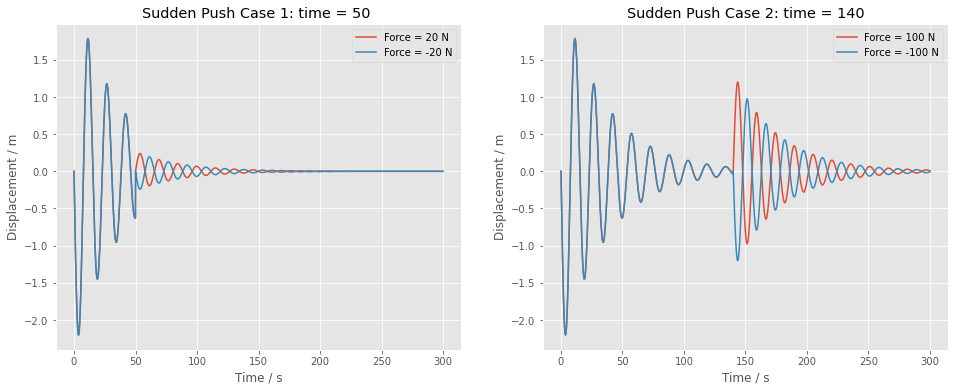

In [73]:
#get values of position when a sudden force is applied
sudden_push_x_1, _ = sudden_push(n_steps, 0.04, 0.2, 20, 50)
sudden_push_x_2, _ = sudden_push(n_steps, 0.04, 0.2, -20, 50)
sudden_push_x_3, _ = sudden_push(n_steps, 0.04, 0.2, 100, 140)
sudden_push_x_4, _ = sudden_push(n_steps, 0.04, 0.2, -100, 140)

plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
plt.plot(time,sudden_push_x_1, label = 'Force = 20 N')
plt.plot(time,sudden_push_x_2, label = 'Force = -20 N')
plt.title('Sudden Push Case 1: time = 50 ')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')
plt.legend()

plt.subplot(1,2,2)
plt.plot(time,sudden_push_x_3, label = 'Force = 100 N')
plt.plot(time,sudden_push_x_4, label = 'Force = -100 N')
plt.title('Sudden Push Case 2: time = 140')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')
plt.legend()

plt.show()


As seen in case 1 the force is applied when the velocity is increasing. This results in a slightly larger peak for the positive force.

As seen in case 2 the force is applied when the velocity is decreasing. This results in a fractionally higher peak for the negative force.

### Sinusoidal applied force

The force applied to the mass can be thought of as:
    $$F(t) = F_0sin(\omega t) \;\;\;\           where \; \omega \neq \omega_0$$ 
where $F_0$ is the force applied at $t=0$, and $\omega$ is the frequency of the applied force driving the system.

The equation observed is as follows
$$\frac{\mathrm{d}^2x }{\mathrm{d} t^2} + \gamma \frac{\mathrm{d} x}{\mathrm{d} t} + \omega_0x = \frac{F_0}{m}sin(\omega t).$$

This is a second order inhomogeneous equation and so the result of it is the sum of the particular integral and complimentary function. This gives 
$$x = x_{tr} + x_{sp},$$
where $x_{tr}$ is the transient motion anf $x_{sp}$ is the steady periodic solution.




One can use Verlet's method as before to find the effect of a periodic force:

In [74]:
def periodic_force(integration_steps, h,  b, driving_freq, F_0):
    """
    funtion that calculates the position and velocity of mass using Verlet's method, and when a sudden push occurs.
    function also calculates the amplitude of the oscillations after the transient period

    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant
    driving_freq : float
        the frequency the wave is driven at
    F_0 : float
        the maximum force the mass is pushed with

    Returns
    -------
    x : numpy array
        the position of the mass
    v : numpy array
        the velocity of the mass at cettain time steps
    amplitude : float
        the amplitude of oscillations after transient motion

    """
    gamma = b/m
    natural_freq_sq = k/m #the square of the natural frequency
    
    F = F_0 * np.sin(driving_freq * time) #Writing the periodic driving force as a function of time
    x = np.zeros(integration_steps)
    v = np.zeros(integration_steps)

    x[0] = x_0
    v[0] = v_0
    a_0 = -gamma*v[0]- natural_freq_sq*x[0] +F[0]/m 
    
    x[1] = x[0] + v[0]*h + a_0*((h**2)/2)
    v[1] = v[0] + a_0*h
    
    for i in range(1, integration_steps-1):
        a = -gamma*v[i]- natural_freq_sq*x[i] +F[i]/m
        x[i+1] = x[i] + h*v[i]+0.5*a*h*h
        a_new = -gamma*v[i+1]- natural_freq_sq*x[i+1] + F[i+1]/m
        v[i+1] = v[i] + 0.5*h*(a+a_new)


    # NOW to find the amplitude of oscillations (after transient period)
    
    #get amplitudes using scipy method find_peaks, and puts index of them in variable peaks
    peaks, _ = find_peaks(x, height = 0)
    
    #need to filter out transient, so compare peaks and if difference between that peak and previous is small,that's amplitude
    for n in range (len(peaks)-1):
        if np.abs(x[peaks[n]] - x[peaks[n-1]]) < 0.0001:
            break
    amplitude = x[peaks[n]]
    
    return(x, v, amplitude)

The plot of a driven system is seen below

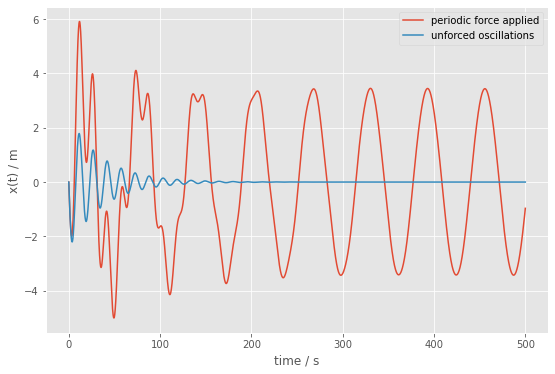

In [75]:
#parameters reset so can see transient motion and then periodic motion
T=500
n_steps = int(T/h)
time = np.linspace(0, T-h, num = n_steps) 

x_periodic, _, _ = periodic_force(n_steps, h, 0.2, 0.1, 2)
x_no_force, _ = verlet(n_steps, h, 0.2)

plt.figure(figsize=(9,6))

plt.plot(time, x_periodic, label = 'periodic force applied')
plt.plot(time, x_no_force, label = 'unforced oscillations')
plt.xlabel('time / s')
plt.ylabel('x(t) / m')
plt.legend()

plt.show()

As seen in the graph above transient motion seems to be a superposition of the unforced oscillations of the system and the periodic force, thus transient motion stops when the "unforced oscillation" stops.

The amplitude of oscillations is explored either side of the natural frequency below:

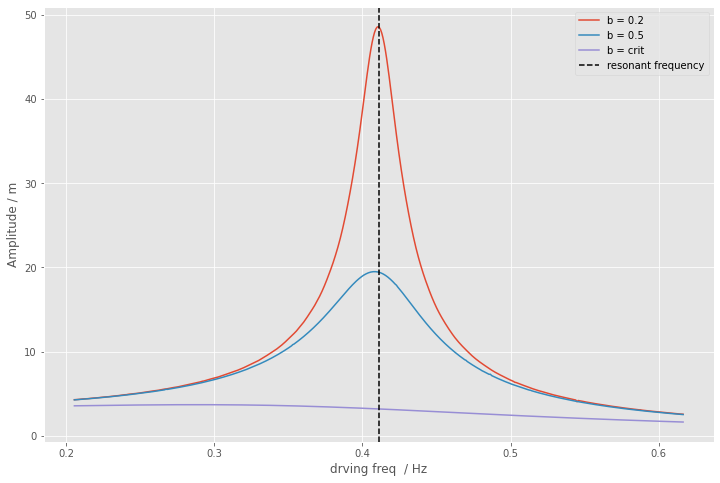

In [76]:
natural_freq = np.sqrt(k/m)
b_crit = 2* np.sqrt(k*m)

driving_freq = np.linspace(0.5 * natural_freq, 1.5 * natural_freq, 500) 

#making zero arrays of the amplitude
amplitude_1 = np.zeros(len(driving_freq))
amplitude_2 = np.zeros(len(driving_freq))
amplitude_3 = np.zeros(len(driving_freq))


#pushed with a force 2N
for i, freq in enumerate(driving_freq):
    _, _, amplitude_1[i] = periodic_force(n_steps, h, 0.2, freq, 2)
    _, _, amplitude_2[i] = periodic_force(n_steps, h, 0.5, freq, 2)
    _, _, amplitude_3[i] = periodic_force(n_steps, h, b_crit, freq, 2)

#produce plot
plt.figure(figsize=(12,8))

plt.plot(driving_freq, amplitude_1, label = 'b = 0.2')
plt.plot(driving_freq, amplitude_2, label = 'b = 0.5')
plt.plot(driving_freq, amplitude_3, label = 'b = crit')
plt.xlabel('drving freq  / Hz')
plt.ylabel('Amplitude / m')
plt.axvline(x = natural_freq, color = 'k', linestyle = '--', label = 'resonant frequency')
plt.legend()

One can see that as the frequency of the force increases the amplitude increases and reaches its maximum at the natural frequency of the oscillator. Also, as the damping coefficient is increased the maximum amplitude of oscillation decreases. Around resonance this is more pronounced and the amplitude of oscillations peaks.

The Quality factor gives a qualitative figure to how well the mass spring system is damped. This is given from a power against frequency graph. 
$$P\propto A^2$$
Power is given as above and the Q factor is given by
$$Q= \frac{f_0}{f_{fwhh}}$$
where the denominator is the full width at half the height of the peak.

In [77]:
def find_Q(power_arr, driving_freq):
    """
    function to find the qualtiy factor of an oscillator

    Parameters
    ----------
    power_arr : numpy array
        array of the power of each point
    driving_freq : numpy array
        array of values of frequency from which amplitude is calculated

    Returns
    -------
    float
        the quality factor
    r1 : float
        the 1st value of frequency at half height 
    r2 : float
        the 2nd value of frequency at half height
    maximum_ind : int
        the index at which the maximum height occurs in the diving freq array

    """
    #find maximum value of frequency
    maximum_ind = np.argmax(power_arr)
    power_at_max = power_arr[maximum_ind]
    maximum = driving_freq[maximum_ind]
    
    #create spline of the power array minus half the power array
    spline = UnivariateSpline(driving_freq, (power_arr)-(power_at_max)/2, s=0)
    r1, r2 = spline.roots() # find the roots
    fwhh = np.abs(r2-r1)
    
    return (maximum/fwhh, r1, r2, maximum_ind)

power_1 = amplitude_1**2
power_2 = amplitude_2**2

Q_1, root1_1, root2_1, max_1 = find_Q(power_1, driving_freq)
Q_2, _, _, _ = find_Q(power_2, driving_freq)

print("The Q factor when b = 0.2 is {0:.2f}".format(Q_1))
print("The Q factor when b = 0.5 is {0:.2f}".format(Q_2))


The Q factor when b = 0.2 is 15.04
The Q factor when b = 0.5 is 5.94


The quality factor calculation can be seen on the graph below. The shaded region represents the full width at half height. The Q factors are in agreement with the plot above, when $b=0.2$ the oscillations are the highest, as seen by the higher Q factor.

NOTE: in order to get an accurate value for the full width at half height the amount of numbers where the frequency is calculated is very large, drastically increasing run time. But otherwise would have inaccurate values.

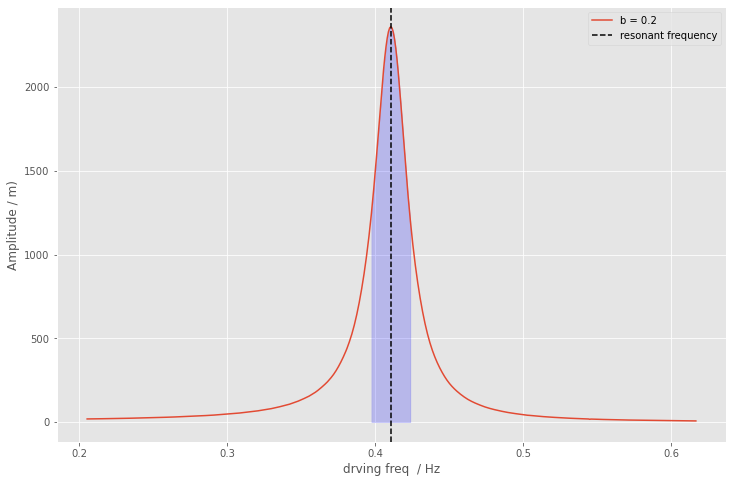

In [78]:
plt.figure(figsize=(12,8))

plt.plot(driving_freq, power_1, label = 'b = 0.2')
plt.xlabel('drving freq  / Hz')
plt.ylabel('Amplitude / m)')
plt.axvline(x = driving_freq[max_1], color = 'k', linestyle = '--', label = 'resonant frequency')
plt.fill_between(driving_freq, power_1, 
                 where = (driving_freq >= root1_1) & (driving_freq <= root2_1), #shades the width at half height
                 facecolor="orange", # The fill color
                 color='blue',       # The outline color
                 alpha=0.2)          # Transparency of the fill
plt.legend()

This values agree with what the graph above shows that the quality of oscillations are better when the damping constant is lower.

### Sustained application of force

If the oscillator is driven by a sustained push for a time L at a certain time t.

This is essentially the sudden push case but over a sustained period of time, and also has a force in the opposite direction for the same time. However, Verlet's method cannot be used as there will be a varying acceleration for a sustained period, and as Verltet is not self-starting it would rely on another method too heavily. Therefore the Euler-Cromer method is used, as it is the next best solution according to graphs above.

Below are graphs with the following cases:
- Case 1: F = 20N and at time 50 the pushing begins for length 0.2s
- Case 2: F = -20N and at time 50 the pushing begins for length 0.2s
- Case 3: F = 20N and at time 50 the pushing begins for length 0.5s
- Case 4: F = -20N and at time 50 the pushing begins for length 0.5s

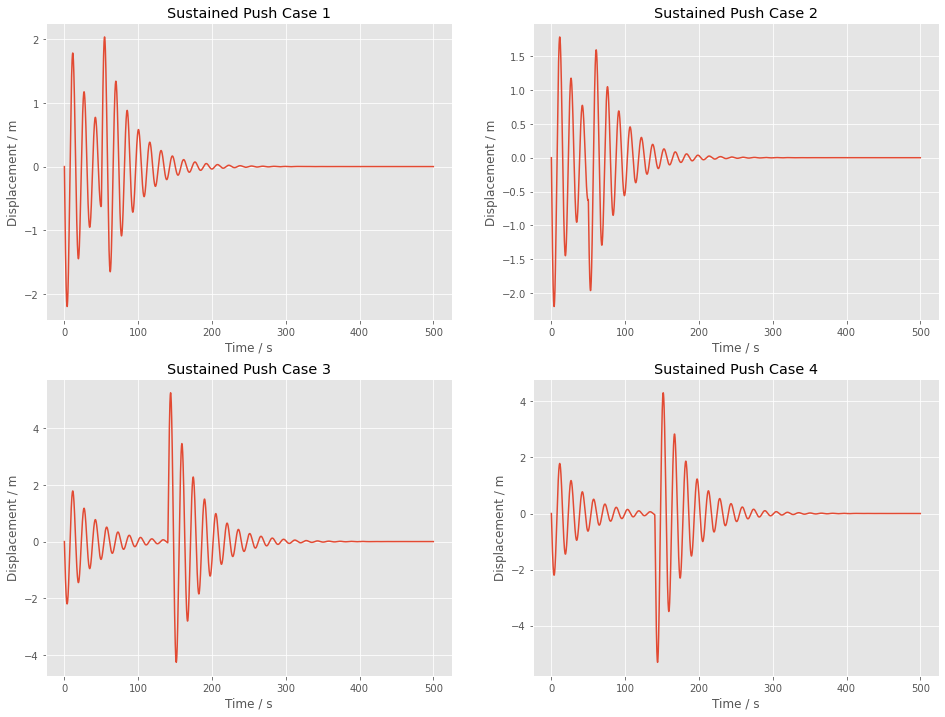

In [79]:
def sustained_push(integration_steps, h, b, F_0, F_time, L):
    """
    function to calculate the amplitude and velocity when there is a force
    that lasts for a certain period of time

    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant
    F_0 : float
        the maximum force the mass is pushed with
    F_time : float
        time at which the force is applied.
    L : float
        how long force is applied for

    Returns
    -------
    x : numpy array
        the position of the mass
    v : numpy array
        the velocity of the mass at cettain time steps

    """
    #create empty array for velocities and positions 
    x = np.zeros(integration_steps)
    v = np.zeros(integration_steps)
    a = np.zeros(integration_steps)
    F = np.zeros(integration_steps)

    F_step_start = int(F_time/h)
    F_step_end = F_step_start + int(L/h)


    for i, _ in enumerate(F):
        if i > F_step_start and i < F_step_end:
            F[i] = F_0

    #insert the initial conditions specified as global constants before
    x[0] = x_0
    v[0] = v_0

    for i in range(n_steps-1):
            a = -(k/m)*x[i] - (b/m)*v[i] + F[i]/m

            # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
            v[i+1] = v[i] + a*h
            x[i+1] = x[i] + v[i+1]*h
            
    return (x, v)

#get amplitudes for each case
sustained_push_x_1, _ = sustained_push(n_steps, 0.04, 0.2, 20, 50, 0.2)
sustained_push_x_2, _ = sustained_push(n_steps, 0.04, 0.2, -20, 50, 0.2)
sustained_push_x_3, _ = sustained_push(n_steps, 0.04, 0.2, 20, 140, 0.5)
sustained_push_x_4, _ = sustained_push(n_steps, 0.04, 0.2, -20, 140, 0.5)

#plot each case
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
plt.plot(time,sustained_push_x_1)
plt.title('Sustained Push Case 1')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')

plt.subplot(2,2,2)
plt.plot(time,sustained_push_x_2)
plt.title('Sustained Push Case 2')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')

plt.subplot(2,2,3)
plt.plot(time,sustained_push_x_3)
plt.title('Sustained Push Case 3')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')

plt.subplot(2,2,4)
plt.plot(time,sustained_push_x_4)
plt.title('Sustained Push Case 4')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')

plt.show()


One can see that the longer the force pushing the object is in contact with the object, the bigger the displacement will be. Figures 3 and 4 have much larger amplitudes after the push than Figures 1 and 2, this results in the oscillations coming to rest at a later time.

### Driven by periodic force (sustained push)

This part takes the last part further in that we are looking at a sustained push but that it pushes the mass periodically, it will push the mass every 50 seconds for example.

Below are graphs with the following cases:
- Case 1: F = 20N and at time 50 the pushing begins for length 0.2s, every 100 seconds
- Case 2: F = -20N and at time 50 the pushing begins for length 0.2s, every 100 seconds
- Case 3: F = 20N and at time 50 the pushing begins for length 0.2s, every 50 seconds
- Case 4: F = -20N and at time 50 the pushing begins for length 0.2s, every 50 seconds

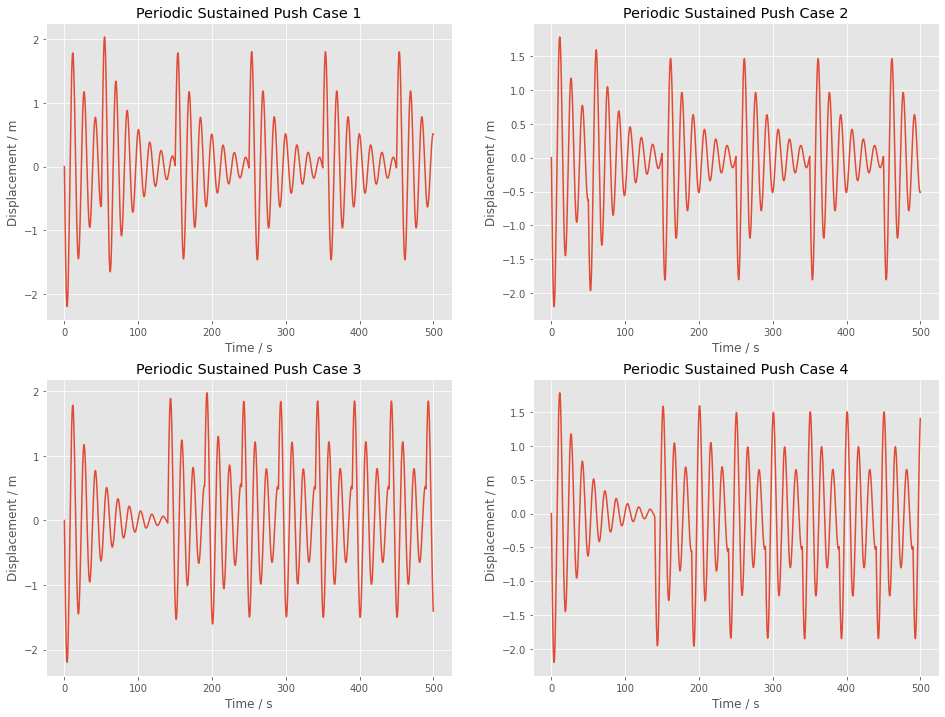

In [80]:
def sustained_periodic_push(integration_steps, h, b, F_0, F_time, L, period):
    """

    Parameters
    ----------
    integration_steps : int
        the amount of steps in the integration done
    h : float
        the step size in the integration done
    b : float
        the damping constant
    F_0 : float
        the maximum force the mass is pushed with
    F_time : float
        time at which the force is applied.
    L : float
        how long force is applied for
    period : float
        how often force is applied

    Returns
    -------
    x : numpy array
        the position of the mass
    v : numpy array
        the velocity of the mass at cettain time steps

    """
    #create empty array for velocities and positions 
    x = np.zeros(integration_steps)
    v = np.zeros(integration_steps)
    a = np.zeros(integration_steps)
    F = np.zeros(integration_steps)
    
     
    F_step_start = int(F_time/h)
    F_step_end = F_step_start + int(L/h)
    
    while True:
        for i, _ in enumerate(F):
            if i > F_step_start and i < F_step_end:
                F[i] = F_0
        F_step_start += int(period/h)
        F_step_end += int(period/h)
        if F_step_end > integration_steps:
            break

    #insert the initial conditions specified as global constants before
    x[0] = x_0
    v[0] = v_0

    for i in range(n_steps-1):
            a = -(k/m)*x[i] - (b/m)*v[i] + F[i]/m

            # For each configuration at step i, calculate x (in m) and v (in m/s) for the later step i+1
            v[i+1] = v[i] + a*h
            x[i+1] = x[i] + v[i+1]*h
            
    return (x, v)

#get amplitudes for each case
sustained_push_x_1, _ = sustained_periodic_push(n_steps, 0.04, 0.2, 20, 50, 0.2, 100)
sustained_push_x_2, _ = sustained_periodic_push(n_steps, 0.04, 0.2, -20, 50, 0.2, 100)
sustained_push_x_3, _ = sustained_periodic_push(n_steps, 0.04, 0.2, 20, 140, 0.2, 50)
sustained_push_x_4, _ = sustained_periodic_push(n_steps, 0.04, 0.2, -20, 140, 0.2, 50)

#plots each case
plt.figure(figsize=(16,12))

plt.subplot(2,2,1)
plt.plot(time,sustained_push_x_1)
plt.title('Periodic Sustained Push Case 1')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')

plt.subplot(2,2,2)
plt.plot(time,sustained_push_x_2)
plt.title('Periodic Sustained Push Case 2')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')

plt.subplot(2,2,3)
plt.plot(time,sustained_push_x_3)
plt.title('Periodic Sustained Push Case 3')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')

plt.subplot(2,2,4)
plt.plot(time,sustained_push_x_4)
plt.title('Periodic Sustained Push Case 4')
plt.xlabel('Time / s')
plt.ylabel('Displacement / m')


plt.show()


One can see that as the period gets smaller the graph resembles a sine wave more and more. One could say that if the period is small enough one gets to the stage where it resembled a sinusoidal push. This is due to the fact the sustained push is essentially a square wave but translated. A square wave when made into Fourier series becomes a superposition of sine waves, and so in this space one can say that they are similar, it just has many sinusoidal forces. 

## Summary

In this project Verlet's method has been demonstrated to be the best numerical integrator due to it's associated low errors. The time step used in the numerical integration is a comprimise between error size (as lower step size means lower error) and the time taken for the method to be completed. This makes the program not only accurate but efficient. After the  oscillating system could be modelled with a force could be modelled using Verlet's method. It was discovered that transient motion ended when the "free oscillations" were negligable.

The Quality factor for different damping constants was able to be found and confirmed with theory. Then different types of pushes were investigated and it was theorised that one could make a superposition of sine waves (using Fourier series) to model certain types of pushes.